Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


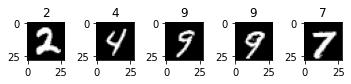

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 24, 24, 64)   1664        input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 10, 10, 64)   36928       max_pooling2d_9[0][0]            
____________________________________________________________________________________________

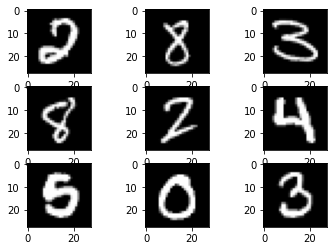

Images Reconstruites par le VAE


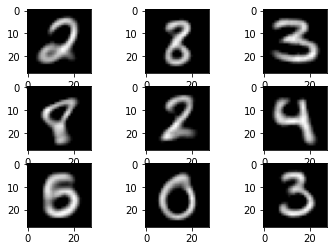

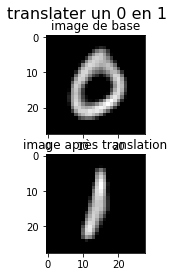

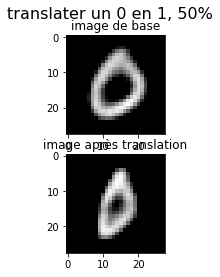

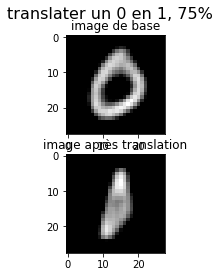

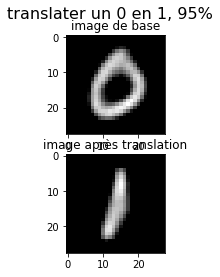

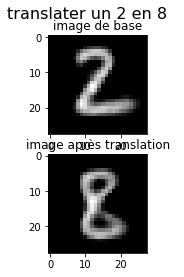

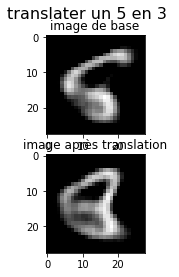

In [4]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
import tensorflow
tensorflow.compat.v1.disable_eager_execution()
from tensorflow.keras.datasets import mnist


"""
VARIABLES
"""

nbrVariables=32 #si !=2 pas de plot en 2D  || Il s'agit du nombre de variables de l'espace latent 
nbrEpochs=1  #3min environ par epoch || nombre d'entrainements réalisés l'erreur décroit logarithmiquement (c'est presque inutile au dela de 10)


"""
"""
def calculvecteur(x1,x2):
    res=[]
    for i in range(len(x1)):
        res.append(x2[i]-x1[i])
    return(res)

def translation(x1,x2,a):
    res=[]
    for i in range(len(x1)):
        res.append(a*x2[i]+x1[i])
    return(res)  

#faire la moyenne des colonnes
def moyenneliste(liste):
    res=[]
    liste=np.array(liste)
    for i in range(len(liste[:][0])):
        res.append(np.mean(liste[:,i]))
    return res

#Téléchargement du dataset (X est l'image y un charactéristique, ici le chiffre écrit de 0 à 9)
(trainX, trainy), (testX, testy) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))

#Affichage de 5 échantillons du dataset d'entrainement
for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainy[i])
plt.show()

#Mise en forme des dataframes avec pandas
#Conversion de toutes les valeurs des 2 datasets en float32 
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255


train_data = np.reshape(train_data, (60000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))

#affichage des dimensions du dataset
#print (train_data.shape, test_data.shape)  #pour mnist : (60000, 28, 28, 1) (10000, 28, 28, 1)



#Création du réseau de neuronne de l'encodeur

input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))

encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Flatten()(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random


distribution_mean = tensorflow.keras.layers.Dense(nbrVariables, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(nbrVariables, name='log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

#Création du réseau de neuronne du décodeur


decoder_input = tensorflow.keras.layers.Input(shape=(nbrVariables))
decoder = tensorflow.keras.layers.Dense(64)(decoder_input)
decoder = tensorflow.keras.layers.Reshape((1, 1, 64))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder_output = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

encoded = encoder_model(input_data)
decoded = decoder_model(encoded)
autoencoder = tensorflow.keras.models.Model(input_data, decoded)



def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss



autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

#tensorflow.config.run_functions_eagerly(True)#experimental_

autoencoder.fit(train_data, train_data, epochs=nbrEpochs, batch_size=64, validation_data=(test_data, test_data))


#Affichage du résultat (avant/après)

offset=400
print ("Images en Entrée")
# Images Réelles 
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(test_data[i+offset,:,:, -1], cmap='gray')
plt.show()

# Images Reconstruites
print ("Images Reconstruites par le VAE")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([test_data[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
plt.show()

#Si le nombre de variables ==2 on peut afficher une carte de l'espace latent 
if nbrVariables==2:
    generator_model = decoder_model
    x_values = np.linspace(-3, 3, 30)
    y_values = np.linspace(-3, 3, 30)
    figure = np.zeros((28 * 30, 28 * 30))
    for ix, x in enumerate(x_values):
        for iy, y in enumerate(y_values):
            latent_point = np.array([[x, y]])
            generated_image = generator_model.predict(latent_point)[0]
            figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = generated_image[:,:,-1]
    
    plt.figure(figsize=(15, 15))
    plt.imshow(figure, cmap='gray', extent=[3,-3,3,-3])
    plt.show()
    
#toutes les données de test dans un espace latent
    x = []
    y = []
    z = []
    for i in range(10000):
        z.append(testy[i])
        op = encoder_model.predict(np.array([test_data[i]]))
        x.append(op[0][0])
        y.append(op[0][1])
    df = pd.DataFrame()
    df['x'] = x
    df['y'] = y
    df['z'] = ["digit-"+str(k) for k in z]

#Test translation dans l'espace latent
    moyenneX=[]
    moyenneY=[]
    for i in range(10):
        resX=[]
        resY=[]
        for j in range(len(x)): 
            if int(i)==int(z[j]):
                resX.append(x[j])
                resY.append(y[j])
        moyenneX.append(np.mean(resX))
        moyenneY.append(np.mean(resY))
    df2 = pd.DataFrame()
    df2['x'] = moyenneX
    df2['y'] = moyenneY
    df2['z'] = ["digit-"+str(k) for k in range(10)]
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='x', y='y', hue='z', data=df)
    plt.show()
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='x', y='y', hue='z', data=df2)
    plt.title("moyenne de l'ensemble des digits")
    plt.show()

    # translater un 0 en 1 
    vecteurTranslationX=moyenneX[1]-moyenneX[0]
    vecteurTranslationY=moyenneY[1]-moyenneY[0]
    i=0
    while int(z[i])!=int(0):
        i=i+1
    latent_point = np.array([[x[i], y[i]]])
    image_base = np.reshape(generator_model.predict(latent_point)[0], (28, 28))
    x2=x[i]+vecteurTranslationX
    y2=y[i]+vecteurTranslationY
    latent_point = np.array([[x2, y2]])
    image_trans = np.reshape(generator_model.predict(latent_point)[0], (28, 28))

    plt.subplot(211)
    plt.imshow(image_base, cmap='gray')
    plt.title("image de base")
    plt.subplot(212)
    plt.imshow(image_trans, cmap='gray')
    plt.title("image après translation")
    plt.suptitle('translater un 0 en 1 ', fontsize=16)
    plt.show()

    # translater un 2 en 8 
    vecteurTranslationX=moyenneX[8]-moyenneX[2]
    vecteurTranslationY=moyenneY[8]-moyenneY[2]
    i=0
    while int(z[i])!=int(2):
        i=i+1
    latent_point = np.array([[x[i], y[i]]])
    image_base = np.reshape(generator_model.predict(latent_point)[0], (28, 28))
    x2=x[i]+vecteurTranslationX
    y2=y[i]+vecteurTranslationY
    latent_point = np.array([[x2, y2]])
    image_trans = np.reshape(generator_model.predict(latent_point)[0], (28, 28))

    plt.subplot(211)
    plt.imshow(image_base, cmap='gray')
    plt.title("image de base")
    plt.subplot(212)
    plt.imshow(image_trans, cmap='gray')
    plt.title("image après translation")
    plt.suptitle('translater un 2 en 8  ', fontsize=16)
    plt.show()

    # translater un 5 en 3
    vecteurTranslationX=moyenneX[3]-moyenneX[5]
    vecteurTranslationY=moyenneY[3]-moyenneY[5]
    i=0
    while int(z[i])!=int(5):
        i=i+1
    latent_point = np.array([[x[i], y[i]]])
    print(latent_point)
    image_base = np.reshape(generator_model.predict(latent_point)[0], (28, 28))
    x2=x[i]+vecteurTranslationX
    y2=y[i]+vecteurTranslationY
    latent_point = np.array([[x2, y2]])
    image_trans = np.reshape(generator_model.predict(latent_point)[0], (28, 28))

    plt.subplot(211)
    plt.imshow(image_base, cmap='gray')
    plt.title("image de base")
    plt.subplot(212)
    plt.imshow(image_trans, cmap='gray')
    plt.title("image après translation")
    plt.suptitle('translater un 5 en 3 ', fontsize=16)
    plt.show()


#Tracé de 10 figures i pour lesquelles espacelatent=[0,...xi,...,0]

# elif nbrVariables==10:
#     generator_model = decoder_model
#     for i in range(10):
#         plt.subplot(5,2,1 + i)
#         list=[0,0,0,0,0,0,0,0,0,0]
#         list[i]=3
#         latent_point=np.array([list])
#         generated_image = generator_model.predict(latent_point)[0]
#         plt.imshow(generated_image[:,:,-1], cmap='gray')
#         plt.title(str(i))
#         list[i]=0
#     plt.show()

#Test translation dans l'espace latent pour n'importe quel nombre de variables
else:
    generator_model = decoder_model
    espacelatent=[]
    valeur=[]
    for i in range(10000):
        valeur.append(testy[i])
        op = encoder_model.predict(np.array([test_data[i]]))
        espacelatent.append(np.reshape(op[0],nbrVariables))
    moyenne=[]
    for i in range(10):
        res=[]
        for j in range(len(espacelatent)): 
            if int(i)==int(valeur[j]):
                res.append(espacelatent[j])
        moyenne.append(moyenneliste(res))

    # translater un 0 en 1 
    vecteurTranslation=calculvecteur(moyenne[0],moyenne[1])
    i=0
    while int(valeur[i])!=int(0):
        i=i+1
    latent_point = np.array([list(espacelatent[i])])
    image_base = np.reshape(generator_model.predict(latent_point)[0], (28, 28))
    espacelatentTrans=translation(espacelatent[i],vecteurTranslation,1)
    latent_point = np.array([espacelatentTrans])
    image_trans = np.reshape(generator_model.predict(latent_point)[0], (28, 28))

    plt.subplot(211)
    plt.imshow(image_base, cmap='gray')
    plt.title("image de base")
    plt.subplot(212)
    plt.imshow(image_trans, cmap='gray')
    plt.title("image après translation")
    plt.suptitle('translater un 0 en 1 ', fontsize=16)
    plt.show()

     # translater un 0 en 1 50%
    vecteurTranslation=calculvecteur(moyenne[0],moyenne[1])
    i=0
    while int(valeur[i])!=int(0):
        i=i+1
    latent_point = np.array([list(espacelatent[i])])
    image_base = np.reshape(generator_model.predict(latent_point)[0], (28, 28))
    espacelatentTrans=translation(espacelatent[i],vecteurTranslation,0.5)
    latent_point = np.array([espacelatentTrans])
    image_trans = np.reshape(generator_model.predict(latent_point)[0], (28, 28))

    plt.subplot(211)
    plt.imshow(image_base, cmap='gray')
    plt.title("image de base")
    plt.subplot(212)
    plt.imshow(image_trans, cmap='gray')
    plt.title("image après translation")
    plt.suptitle('translater un 0 en 1, 50%', fontsize=16)
    plt.show()




     # translater un 0 en 1 75%
    vecteurTranslation=calculvecteur(moyenne[0],moyenne[1])
    i=0
    while int(valeur[i])!=int(0):
        i=i+1
    latent_point = np.array([list(espacelatent[i])])
    image_base = np.reshape(generator_model.predict(latent_point)[0], (28, 28))
    espacelatentTrans=translation(espacelatent[i],vecteurTranslation,0.75)
    latent_point = np.array([espacelatentTrans])
    image_trans = np.reshape(generator_model.predict(latent_point)[0], (28, 28))

    plt.subplot(211)
    plt.imshow(image_base, cmap='gray')
    plt.title("image de base")
    plt.subplot(212)
    plt.imshow(image_trans, cmap='gray')
    plt.title("image après translation")
    plt.suptitle('translater un 0 en 1, 75%', fontsize=16)
    plt.show()

     # translater un 0 en 1 95%
    vecteurTranslation=calculvecteur(moyenne[0],moyenne[1])
    i=0
    while int(valeur[i])!=int(0):
        i=i+1
    latent_point = np.array([list(espacelatent[i])])
    image_base = np.reshape(generator_model.predict(latent_point)[0], (28, 28))
    espacelatentTrans=translation(espacelatent[i],vecteurTranslation,0.95)
    latent_point = np.array([espacelatentTrans])
    image_trans = np.reshape(generator_model.predict(latent_point)[0], (28, 28))

    plt.subplot(211)
    plt.imshow(image_base, cmap='gray')
    plt.title("image de base")
    plt.subplot(212)
    plt.imshow(image_trans, cmap='gray')
    plt.title("image après translation")
    plt.suptitle('translater un 0 en 1, 95%', fontsize=16)
    plt.show()


    # translater un 2 en 8 
    vecteurTranslation=calculvecteur(moyenne[2],moyenne[8])
    i=0
    while int(valeur[i])!=int(2):
        i=i+1
    latent_point = np.array([list(espacelatent[i])])
    image_base = np.reshape(generator_model.predict(latent_point)[0], (28, 28))
    espacelatentTrans=translation(espacelatent[i],vecteurTranslation,1)
    latent_point = np.array([espacelatentTrans])
    image_trans = np.reshape(generator_model.predict(latent_point)[0], (28, 28))

    plt.subplot(211)
    plt.imshow(image_base, cmap='gray')
    plt.title("image de base")
    plt.subplot(212)
    plt.imshow(image_trans, cmap='gray')
    plt.title("image après translation")
    plt.suptitle('translater un 2 en 8  ', fontsize=16)
    plt.show()

    # translater un 5 en 3
    vecteurTranslation=calculvecteur(moyenne[5],moyenne[3])
    i=0
    while int(valeur[i])!=int(5):
        i=i+1
    latent_point = np.array([list(espacelatent[i])])
    image_base = np.reshape(generator_model.predict(latent_point)[0], (28, 28))
    espacelatentTrans=translation(espacelatent[i],vecteurTranslation,1)
    latent_point = np.array([espacelatentTrans])
    image_trans = np.reshape(generator_model.predict(latent_point)[0], (28, 28))

    plt.subplot(211)
    plt.imshow(image_base, cmap='gray')
    plt.title("image de base")
    plt.subplot(212)
    plt.imshow(image_trans, cmap='gray')
    plt.title("image après translation")
    plt.suptitle('translater un 5 en 3 ', fontsize=16)
    plt.show()